In [1]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import warnings
from pandas.plotting import scatter_matrix
from sklearn import metrics
import seaborn as sn
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from xgboost import XGBClassifier
from xgboost import plot_importance
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from collections import Counter
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import RepeatedStratifiedKFold
from skopt import BayesSearchCV
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE, BorderlineSMOTE, SMOTENC, SVMSMOTE, KMeansSMOTE, ADASYN
from sklearn.model_selection import GridSearchCV
from imblearn.pipeline import Pipeline
from data_processing import (identify_merger, clean_hcris_before_2010, clean_hcris_after_2010, imputation_method, resampling)
from grid_search import (grid_search_lr, grid_search_lda, grid_search_knn, grid_search_dt, grid_search_rf, grid_search_xgb)

In [2]:
# ignore warnings
warnings.filterwarnings("ignore")
# Set the display options
pd.set_option('display.max_columns',200)
pd.set_option('display.max_rows',200)
pd.options.mode.use_inf_as_na = True

# Data preparation

Firstly, I upload the verified data from Lina and identify the potential mergers (details see identify_merger() in data_processing.py).\
Return the data after identification as a dataframe (df1).\
Drop the 'Year of change' after 2012.

In [3]:
verified_data = identify_merger()
verified_data.drop(verified_data[verified_data['Year of change']==2017].index,inplace=True)
verified_data.drop(verified_data[verified_data['Year of change']==2016].index,inplace=True)
verified_data.drop(verified_data[verified_data['Year of change']==2015].index,inplace=True)
verified_data.drop(verified_data[verified_data['Year of change']==2014].index,inplace=True)
verified_data.drop(verified_data[verified_data['Year of change']==2013].index,inplace=True)

         id  Type of closure  \
0     10009              1.0   
1     10010              5.0   
2     10015              1.0   
3     10025              4.0   
4     10027              1.0   
..      ...              ...   
365  670018              1.0   
366  670021              4.0   
367  670029              5.0   
368  670052              4.0   
369  670066              4.0   

    Type of change (Convert/close/merge/change names)  Year of change  merged  
0                                               Close          2012.0       0  
1                                                Open             NaN       0  
2                                               Close          2011.0       0  
3                                         Open/merger          2013.0       1  
4                                               Close          2013.0       0  
..                                                ...             ...     ...  
365      Close, reopen in 2015 but probably partially  

Upload HCRIS data 2001-2012

In [4]:
# HCRIS 2001-2012 except 2010
hcris_2012 = pd.read_csv('ime_gme2552_10_2012.csv')
hcris_2011 = pd.read_csv('ime_gme2552_10_2011.csv')
hcris_2009 = pd.read_csv('ime_gme2552_96_2009.csv')
hcris_2008 = pd.read_csv('ime_gme2552_96_2008.csv')
hcris_2007 = pd.read_csv('ime_gme2552_96_2007.csv')
hcris_2006 = pd.read_csv('ime_gme2552_96_2006.csv')
hcris_2005 = pd.read_csv('ime_gme2552_96_2005.csv')
hcris_2004 = pd.read_csv('ime_gme2552_96_2004.csv')
hcris_2003 = pd.read_csv('ime_gme2552_96_2003.csv')
hcris_2002 = pd.read_csv('ime_gme2552_96_2002.csv')
hcris_2001 = pd.read_csv('ime_gme2552_96_2001.csv')
# HCRIS 2010
hcris_2010_1 = pd.read_csv('ime_gme2552_10_2010.csv')
hcris_2010_2 = pd.read_csv('ime_gme2552_96_2010.csv')
hcris_2010 = pd.merge(hcris_2010_1, hcris_2010_2, how='outer')

HCRIS_2012 data as another dataframe (df2).

In [5]:
# Match the column names with df1
hcris_2012.rename(columns={'provider': 'id'}, inplace=True)
print(f"The shape of original HCRIS 2012:{hcris_2012.shape}")

The shape of original HCRIS 2012:(6227, 41)


Check how many common (merged) hospitals between verified and HCRIS.

In [6]:
verified_hcris_common = pd.merge(verified_data, hcris_2012)
verified_hcris_common_merged = verified_hcris_common.loc[verified_hcris_common['merged'].isin([1])]
print(f'Common hospitals: {verified_hcris_common.shape}')
print(f'Common merged hospitals: {verified_hcris_common_merged.shape}')
verified_hcris_common_merged.head(20)

Common hospitals: (122, 45)
Common merged hospitals: (56, 45)


,id,Type of closure,Type of change (Convert/close/merge/change names),Year of change,merged,prvdr_num,fyb,fybstr,fye,fyestr,status,hospital_name,street_addr,po_box,city,state,zip_code,county,ime1,ime2,ime3,dsh1,dsh2,dsh3,dshpct,gme_part_a,gme_part_b,beds,bed_days,medicare_days,medicaid_days,days,intres,employees,volunteers,medicare_disch,medicaid_disch,discharges,medicaid_hmo_discharges,medicaid_hmo_ipf_subprovider,medicaid_hmo_irf_subprovider,medicaid_ipf_subprovider,medicaid_irf_subprovider,total_discharges_subprovider_ipf,total_discharges_subprovider_irf
2,10137,3.0,"Service reduction, specialty clinics",NaN,1,10137,10/1/2011,01-OCT-11,9/30/2012,30-SEP-12,As Submitted,COOPER GREEN MERCY HOSPITAL,1515 SIXTH AVENUE SOUTH,NaN,BIRMINGHAM,AL,35233,JEFFERSON,55245.0,NaN,NaN,384237.0,NaN,NaN,0.4494,111732.0,74964.0,149.0,54385.0,792.0,6456.0,12741.0,25.000000,650.150024,NaN,153.0,1783.0,2488.0,NaN,NaN,NaN,NaN,NaN,62.0,NaN
6,30100,3.0,"Open, merger",NaN,1,30100,10/1/2011,01-OCT-11,6/30/2012,30-JUN-12,Reopened,CARONDELET HEART AND VASCULAR INSTIT,4888 NORTH STONE DRIVE,NaN,TUCSON,AZ,85704-,PIMA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,60.0,16440.0,2692.0,513.0,6563.0,NaN,219.309998,NaN,615.0,155.0,1637.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,30100,3.0,"Open, merger",NaN,1,30100,7/1/2012,01-JUL-12,11/7/2012,07-NOV-12,Settled,CARONDELET HEART AND VASCULAR INSTIT,4888 NORTH STONE DRIVE,NaN,TUCSON,AZ,85704-,PIMA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,60.0,7800.0,584.0,143.0,1487.0,NaN,175.119995,NaN,135.0,42.0,414.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,50016,3.0,Open/merged multiple times,NaN,1,50016,7/1/2012,01-JUL-12,1/9/2013,09-JAN-13,Settled,ARROYO GRANDE COMMUNITY HOSPITAL,345 SOUTH HALCYON ROAD,NaN,ARROYO GRANDE,CA,93420,SAN LUIS OBISPO,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,53.0,19345.0,2067.0,99.0,7578.0,NaN,255.000000,NaN,573.0,19.0,2273.0,NaN,NaN,NaN,NaN,4.0,NaN,369.0
17,50752,4.0,"Open, name change",NaN,1,50752,1/1/2012,01-JAN-12,12/31/2012,31-DEC-12,Settled,BROTMAN MEDICAL CENTER,3828 DELMAS TERRACE,NaN,CULVER CITY,CA,90232,LOS ANGELES,NaN,NaN,NaN,7086722.0,NaN,NaN,0.2970,NaN,NaN,283.0,103578.0,16896.0,5263.0,35870.0,NaN,607.000000,NaN,2893.0,894.0,7021.0,NaN,NaN,NaN,756.0,11.0,1736.0,417.0
18,70001,4.0,"Open, merger and name change",NaN,1,70001,10/1/2011,01-OCT-11,9/11/2012,11-SEP-12,Settled,HOSPITAL OF SAINT RAPHAEL,1450 CHAPEL STREET,NaN,NEW HAVEN,CT,06511,NEW HAVEN,15952772.0,NaN,NaN,6427300.0,NaN,NaN,0.0853,6012769.0,1411530.0,411.0,142617.0,43996.0,10199.0,90680.0,127.730003,2954.719971,NaN,7743.0,2886.0,18852.0,NaN,NaN,NaN,246.0,NaN,712.0,379.0
19,70015,4.0,"Open, merger and name change",NaN,1,70015,10/1/2011,01-OCT-11,9/30/2012,30-SEP-12,Settled,NEW MILFORD HOSPITAL,21 ELM STREET,NaN,NEW MILFORD,CT,06776,UNITED STATES,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,85.0,31110.0,4591.0,822.0,8537.0,NaN,429.799988,5.26,1008.0,244.0,2288.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
26,110219,4.0,"Open, name change",NaN,1,110219,6/1/2012,01-JUN-12,12/31/2012,31-DEC-12,Reopened,SOUTH FULTON MEDICAL CENTER,1170 CLEVELAND AVE,NaN,EAST POINT,GA,30344,FULTON,62535.0,NaN,NaN,1923494.0,NaN,NaN,0.3551,116885.0,32265.0,198.0,42372.0,4546.0,4697.0,14984.0,6.130000,453.799988,NaN,789.0,888.0,2831.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
27,140051,4.0,"Open, name change",NaN,1,140051,10/1/2011,01-OCT-11,9/30/2012,30-SEP-12,Settled,SKOKIE HOSPITAL,9600 GROSS POINT ROAD,NaN,SKOKIE,IL,60076,COOK,2666080.0,NaN,NaN,2955137.0,NaN,NaN,0.0915,1098461.0,429646.0,128.0,52096.0,19373.0,4579.0,31015.0,20.379999,762.799988,NaN,3811.0,409.0,6644.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
29,150003,4.0,"Open, name change",NaN,1,150003,1/1/2012,01-JAN-12,12/31/2012,31-DEC-12,Reopened,ST. ELIZABETH CENTRAL,1501 HARTFORD STREET,NaN,LAFAYETTE,IN,47904-,TIPPECANOE,NaN,NaN,NaN,305820.0,101619.0,NaN,0.0442,NaN,NaN,94.0,34404.0,6966.0,1521.0,11913.0,NaN,535.570007,NaN,1609.0,406.0,2910.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Merge two dataframes by hospital ids.

In [7]:
verified_hcris_data = pd.merge(verified_data, hcris_2012, how='outer')
# Fill the value of column 'merged' in hosp_data not included in verified_data with 0
verified_hcris_data = verified_hcris_data.fillna({'merged':0})
print(verified_hcris_data.shape)

(6408, 45)


# Data cleaning

Drop duplicates and keep the latest date information.

In [8]:
# Return DataFrame with duplicate rows removed except for the id with the recent date.
verified_hcris_data.drop_duplicates(subset=['id'], keep='last', inplace=True)
verified_hcris_data.sort_values(by='id', ascending=True, inplace = True)
verified_hcris_data.reset_index(drop=True, inplace = True)
print(verified_hcris_data.shape)
verified_hcris_data.head(20)

(6313, 45)


,id,Type of closure,Type of change (Convert/close/merge/change names),Year of change,merged,prvdr_num,fyb,fybstr,fye,fyestr,status,hospital_name,street_addr,po_box,city,state,zip_code,county,ime1,ime2,ime3,dsh1,dsh2,dsh3,dshpct,gme_part_a,gme_part_b,beds,bed_days,medicare_days,medicaid_days,days,intres,employees,volunteers,medicare_disch,medicaid_disch,discharges,medicaid_hmo_discharges,medicaid_hmo_ipf_subprovider,medicaid_hmo_irf_subprovider,medicaid_ipf_subprovider,medicaid_irf_subprovider,total_discharges_subprovider_ipf,total_discharges_subprovider_irf
0,10001,NaN,NaN,NaN,0.0,10001.0,10/1/2011,01-OCT-11,9/30/2012,30-SEP-12,Amended,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,6987,DOTHAN,AL,36301,HOUSTON,NaN,NaN,NaN,8633626.0,NaN,NaN,0.1498,NaN,NaN,408.0,149328.0,42785.0,15986.0,87760.0,NaN,2160.600098,NaN,7790.0,3931.0,17435.0,NaN,NaN,NaN,NaN,NaN,215.0,NaN
1,10005,NaN,NaN,NaN,0.0,10005.0,10/1/2011,01-OCT-11,9/30/2012,30-SEP-12,Reopened,MARSHALL MEDICAL CENTER - SOUTH,2505 U.S. HIGHWAY 431,NaN,BOAZ,AL,35957-,MARSHALL,NaN,NaN,NaN,2891397.0,NaN,NaN,0.1253,NaN,NaN,204.0,74664.0,17787.0,6381.0,36415.0,NaN,1056.020020,NaN,3797.0,1291.0,9168.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,10006,NaN,NaN,NaN,0.0,10006.0,7/1/2012,01-JUL-12,6/30/2013,30-JUN-13,Reopened,ELIZA COFFEE MEMORIAL HOSPITAL,205 MARENGO STREET,818,FLORENCE,AL,35630,LAUDERDALE,NaN,NaN,NaN,3498027.0,NaN,NaN,0.0951,NaN,NaN,358.0,130670.0,28599.0,7909.0,52665.0,NaN,968.530029,NaN,5039.0,1765.0,10862.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,10007,NaN,NaN,NaN,0.0,10007.0,10/1/2011,01-OCT-11,9/30/2012,30-SEP-12,Settled,MIZELL MEMORIAL HOSPITAL,702 MAIN STREET,429,OPP,AL,36462-,COVINGTON,NaN,NaN,NaN,185865.0,NaN,NaN,0.0533,NaN,NaN,78.0,28548.0,4122.0,619.0,5867.0,NaN,153.449997,NaN,819.0,133.0,1302.0,NaN,NaN,NaN,NaN,NaN,262.0,NaN
4,10008,NaN,NaN,NaN,0.0,10008.0,1/1/2012,01-JAN-12,12/31/2012,31-DEC-12,Amended,CRENSHAW COMMUNITY HOSPITAL,CRENSHAW COMMUNITY HOSPITAL,101 HOSPITAL CIRCLE,LUVERNE,AL,36049,CRENSHAW,NaN,NaN,NaN,287870.0,NaN,NaN,0.1713,NaN,NaN,29.0,10614.0,1764.0,668.0,3240.0,NaN,106.699997,NaN,374.0,166.0,744.0,NaN,NaN,NaN,104.0,NaN,540.0,NaN
5,10009,1.0,Close,2012.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,10010,5.0,Open,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,10011,NaN,NaN,NaN,0.0,10011.0,7/1/2012,01-JUL-12,6/30/2013,30-JUN-13,Amended,ST. VINCENTS EAST,50 MEDICAL PARK DRIVE EAST,NaN,BIRMINGHAM,AL,35235-,JEFFERSON,1670142.0,NaN,NaN,2023583.0,NaN,NaN,0.0612,787021.0,229995.0,279.0,101835.0,23284.0,10013.0,75795.0,14.660000,1101.239990,NaN,4117.0,1683.0,14380.0,NaN,NaN,NaN,27.0,4.0,421.0,232.0
8,10012,NaN,NaN,NaN,0.0,10012.0,4/1/2012,01-APR-12,3/31/2013,31-MAR-13,Settled,DEKALB REGIONAL MEDICAL CENTER,200 MEDICAL CENTER DRIVE,NaN,FORT PAYNE,AL,35967,DEKALB,NaN,NaN,NaN,928833.0,NaN,NaN,0.1200,NaN,NaN,97.0,35405.0,5771.0,2818.0,13469.0,NaN,371.500000,NaN,1416.0,844.0,3758.0,NaN,NaN,NaN,11.0,NaN,332.0,NaN
9,10015,1.0,Close,2011.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


After combining the two dataframes, I found some hospitals with blank information for almost all columns except 'id' and 'merged'.\
They're likely to close or merge before year 2012.\
So fill those hospitals information with previous HCRIS data.

Clean the previous HCRIS data.

In [9]:
# 2010, 2011
hcris_2011 = clean_hcris_after_2010(hcris_2011)
hcris_2010 = clean_hcris_after_2010(hcris_2010)
# 2001-2009
hcris_2009 = clean_hcris_before_2010(hcris_2009)
hcris_2008 = clean_hcris_before_2010(hcris_2008)
hcris_2007 = clean_hcris_before_2010(hcris_2007)
hcris_2006 = clean_hcris_before_2010(hcris_2006)
hcris_2005 = clean_hcris_before_2010(hcris_2005)
hcris_2004 = clean_hcris_before_2010(hcris_2004)
hcris_2003 = clean_hcris_before_2010(hcris_2003)
hcris_2002 = clean_hcris_before_2010(hcris_2002)
hcris_2001 = clean_hcris_before_2010(hcris_2001)

Fill the missing values  with previous HCRIS data

In [10]:
# Copy the data to store both original and modified data
verified_hcris_data_new = verified_hcris_data
# To store the potential closed ids of hospitals (closed before 2012)
closed_ids = []
# Find the index of potential closed id and locate the index to get the corresponding id.
for index in range(len(verified_hcris_data)):
    if verified_hcris_data.iloc[index, :].isnull().sum() >= 40:
        closed_ids.append(verified_hcris_data.iloc[index, 0])
# Search the closed id in previous years' HCRIS data
hcris_prev = [hcris_2011, hcris_2010, hcris_2009, hcris_2008, hcris_2007, hcris_2006,
              hcris_2005, hcris_2004, hcris_2003, hcris_2002, hcris_2001]
for id in closed_ids:
    for data in hcris_prev:
        # Find the location of the id in previous years' data one year after one year.
        closed_ids_prev = data.loc[data['id'].isin([
            id])]
        if not closed_ids_prev.empty:
            closed_index_2012 = verified_hcris_data_new[
                verified_hcris_data.id == id].index
            verified_hcris_data_new.loc[closed_index_2012, ['ime1', 'ime2', 'ime3', 'dsh1', 'dsh2', 'dsh3', 'gme_part_a', 'gme_part_b', 'beds', 'bed_days', 'medicare_days',
                                                            'medicaid_days', 'days', 'employees', 'volunteers', 'medicare_disch', 'medicaid_disch', 'discharges']] = data.loc[closed_ids_prev.index, ['ime1', 'ime2', 'ime3', 'dsh1', 'dsh2', 'dsh3', 'gme_part_a', 'gme_part_b', 'beds', 'bed_days', 'medicare_days',
                                                                                                                                                                                                      'medicaid_days', 'days', 'employees', 'volunteers', 'medicare_disch', 'medicaid_disch', 'discharges']]
            break
verified_hcris_data_new.head(20)

,id,Type of closure,Type of change (Convert/close/merge/change names),Year of change,merged,prvdr_num,fyb,fybstr,fye,fyestr,status,hospital_name,street_addr,po_box,city,state,zip_code,county,ime1,ime2,ime3,dsh1,dsh2,dsh3,dshpct,gme_part_a,gme_part_b,beds,bed_days,medicare_days,medicaid_days,days,intres,employees,volunteers,medicare_disch,medicaid_disch,discharges,medicaid_hmo_discharges,medicaid_hmo_ipf_subprovider,medicaid_hmo_irf_subprovider,medicaid_ipf_subprovider,medicaid_irf_subprovider,total_discharges_subprovider_ipf,total_discharges_subprovider_irf
0,10001,NaN,NaN,NaN,0.0,10001.0,10/1/2011,01-OCT-11,9/30/2012,30-SEP-12,Amended,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,6987,DOTHAN,AL,36301,HOUSTON,NaN,NaN,NaN,8633626.0,NaN,NaN,0.1498,NaN,NaN,408.0,149328.0,42785.0,15986.0,87760.0,NaN,2160.600098,NaN,7790.0,3931.0,17435.0,NaN,NaN,NaN,NaN,NaN,215.0,NaN
1,10005,NaN,NaN,NaN,0.0,10005.0,10/1/2011,01-OCT-11,9/30/2012,30-SEP-12,Reopened,MARSHALL MEDICAL CENTER - SOUTH,2505 U.S. HIGHWAY 431,NaN,BOAZ,AL,35957-,MARSHALL,NaN,NaN,NaN,2891397.0,NaN,NaN,0.1253,NaN,NaN,204.0,74664.0,17787.0,6381.0,36415.0,NaN,1056.020020,NaN,3797.0,1291.0,9168.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,10006,NaN,NaN,NaN,0.0,10006.0,7/1/2012,01-JUL-12,6/30/2013,30-JUN-13,Reopened,ELIZA COFFEE MEMORIAL HOSPITAL,205 MARENGO STREET,818,FLORENCE,AL,35630,LAUDERDALE,NaN,NaN,NaN,3498027.0,NaN,NaN,0.0951,NaN,NaN,358.0,130670.0,28599.0,7909.0,52665.0,NaN,968.530029,NaN,5039.0,1765.0,10862.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,10007,NaN,NaN,NaN,0.0,10007.0,10/1/2011,01-OCT-11,9/30/2012,30-SEP-12,Settled,MIZELL MEMORIAL HOSPITAL,702 MAIN STREET,429,OPP,AL,36462-,COVINGTON,NaN,NaN,NaN,185865.0,NaN,NaN,0.0533,NaN,NaN,78.0,28548.0,4122.0,619.0,5867.0,NaN,153.449997,NaN,819.0,133.0,1302.0,NaN,NaN,NaN,NaN,NaN,262.0,NaN
4,10008,NaN,NaN,NaN,0.0,10008.0,1/1/2012,01-JAN-12,12/31/2012,31-DEC-12,Amended,CRENSHAW COMMUNITY HOSPITAL,CRENSHAW COMMUNITY HOSPITAL,101 HOSPITAL CIRCLE,LUVERNE,AL,36049,CRENSHAW,NaN,NaN,NaN,287870.0,NaN,NaN,0.1713,NaN,NaN,29.0,10614.0,1764.0,668.0,3240.0,NaN,106.699997,NaN,374.0,166.0,744.0,NaN,NaN,NaN,104.0,NaN,540.0,NaN
5,10009,1.0,Close,2012.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,175131.0,NaN,NaN,NaN,NaN,NaN,130.0,47450.0,2148.0,293.0,3153.0,NaN,108.370003,NaN,572.0,104.0,967.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,10010,5.0,Open,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1112826.0,NaN,NaN,NaN,NaN,NaN,90.0,32850.0,10194.0,2185.0,18949.0,NaN,477.600006,NaN,2278.0,482.0,4712.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,10011,NaN,NaN,NaN,0.0,10011.0,7/1/2012,01-JUL-12,6/30/2013,30-JUN-13,Amended,ST. VINCENTS EAST,50 MEDICAL PARK DRIVE EAST,NaN,BIRMINGHAM,AL,35235-,JEFFERSON,1670142.0,NaN,NaN,2023583.0,NaN,NaN,0.0612,787021.0,229995.0,279.0,101835.0,23284.0,10013.0,75795.0,14.660000,1101.239990,NaN,4117.0,1683.0,14380.0,NaN,NaN,NaN,27.0,4.0,421.0,232.0
8,10012,NaN,NaN,NaN,0.0,10012.0,4/1/2012,01-APR-12,3/31/2013,31-MAR-13,Settled,DEKALB REGIONAL MEDICAL CENTER,200 MEDICAL CENTER DRIVE,NaN,FORT PAYNE,AL,35967,DEKALB,NaN,NaN,NaN,928833.0,NaN,NaN,0.1200,NaN,NaN,97.0,35405.0,5771.0,2818.0,13469.0,NaN,371.500000,NaN,1416.0,844.0,3758.0,NaN,NaN,NaN,11.0,NaN,332.0,NaN
9,10015,1.0,Close,2011.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9767.0,NaN,NaN,NaN,NaN,NaN,27.0,3699.0,295.0,NaN,592.0,NaN,75.029999,NaN,92.0,30.0,204.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Clean the data by dropping columns with more than 60% of the values are missing.

In [11]:
# Find the columns with nan greater than 60%
for column in verified_hcris_data_new:
    count_nan = verified_hcris_data_new[column].isna().sum()
    nan_pct = count_nan/len(verified_hcris_data_new[column])*100
    print(f"{column} has {round(nan_pct,2)}% nan")
    if nan_pct > 60:
        verified_hcris_data_new = verified_hcris_data_new.drop(column, axis=1)

id has 0.0% nan
Type of closure has 95.31% nan
Type of change (Convert/close/merge/change names) has 95.31% nan
Year of change has 98.65% nan
merged has 0.0% nan
prvdr_num has 2.87% nan
fyb has 2.87% nan
fybstr has 2.87% nan
fye has 2.87% nan
fyestr has 2.87% nan
status has 2.87% nan
hospital_name has 2.87% nan
street_addr has 2.93% nan
po_box has 85.0% nan
city has 2.87% nan
state has 2.87% nan
zip_code has 2.87% nan
county has 4.72% nan
ime1 has 83.34% nan
ime2 has 99.89% nan
ime3 has 100.0% nan
dsh1 has 56.2% nan
dsh2 has 99.65% nan
dsh3 has 100.0% nan
dshpct has 56.28% nan
gme_part_a has 83.35% nan
gme_part_b has 81.75% nan
beds has 4.36% nan
bed_days has 4.34% nan
medicare_days has 5.08% nan
medicaid_days has 13.39% nan
days has 4.44% nan
intres has 81.02% nan
employees has 5.16% nan
volunteers has 99.05% nan
medicare_disch has 5.12% nan
medicaid_disch has 13.07% nan
discharges has 4.45% nan
medicaid_hmo_discharges has 100.0% nan
medicaid_hmo_ipf_subprovider has 100.0% nan
medicai

Convert non-numerical columns into numeric ones.

In [12]:
verified_hcris_data_new['state'] = verified_hcris_data_new['state'].astype(str)
verified_hcris_data_new['status_cat'] = LabelEncoder().fit_transform(verified_hcris_data_new['status'])
verified_hcris_data_new['state_cat'] = LabelEncoder().fit_transform(verified_hcris_data_new['state'])
verified_hcris_data_new['city_cat'] = LabelEncoder().fit_transform(verified_hcris_data_new['city'])
verified_hcris_data_new['county_cat'] = LabelEncoder().fit_transform(verified_hcris_data_new['county'])
# drop the non-numerical columns
verified_hcris_data_new = verified_hcris_data_new.drop(['status', 'state', 'city', 'county', 'prvdr_num', 'fyb', 'fybstr', 'fye', 'fyestr', 'hospital_name', 'street_addr', 'zip_code'], axis=1)

In [13]:
verified_hcris_data_new.reset_index(drop=True, inplace=True)
for index in range(len(verified_hcris_data_new)):
    if verified_hcris_data_new.loc[index, :].isnull().sum() >= 11:
        if verified_hcris_data_new.loc[index,'merged']==0:
            verified_hcris_data_new.drop(index,inplace=True)
verified_hcris_data_new.reset_index(drop=True, inplace = True)

# Check the final data after data cleaning.

(6106, 17)
merged
0.0    5990
1.0     116
dtype: int64
Class 1: 1.8997707173272191%


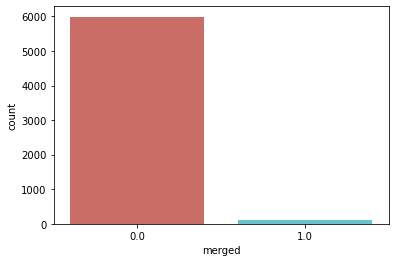

,id,merged,dsh1,dshpct,beds,bed_days,medicare_days,medicaid_days,days,employees,medicare_disch,medicaid_disch,discharges,status_cat,state_cat,city_cat,county_cat
0,10001,0.0,8633626.0,0.1498,408.0,149328.0,42785.0,15986.0,87760.0,2160.600098,7790.0,3931.0,17435.0,0,1,756,704
1,10005,0.0,2891397.0,0.1253,204.0,74664.0,17787.0,6381.0,36415.0,1056.020020,3797.0,1291.0,9168.0,2,1,290,939
2,10006,0.0,3498027.0,0.0951,358.0,130670.0,28599.0,7909.0,52665.0,968.530029,5039.0,1765.0,10862.0,2,1,941,855
3,10007,0.0,185865.0,0.0533,78.0,28548.0,4122.0,619.0,5867.0,153.449997,819.0,133.0,1302.0,3,1,2072,376
4,10008,0.0,287870.0,0.1713,29.0,10614.0,1764.0,668.0,3240.0,106.699997,374.0,166.0,744.0,0,1,1639,387
5,10009,0.0,175131.0,NaN,130.0,47450.0,2148.0,293.0,3153.0,108.370003,572.0,104.0,967.0,5,55,3172,1739
6,10010,0.0,1112826.0,NaN,90.0,32850.0,10194.0,2185.0,18949.0,477.600006,2278.0,482.0,4712.0,5,55,3172,1739
7,10011,0.0,2023583.0,0.0612,279.0,101835.0,23284.0,10013.0,75795.0,1101.239990,4117.0,1683.0,14380.0,0,1,259,755
8,10012,0.0,928833.0,0.1200,97.0,35405.0,5771.0,2818.0,13469.0,371.500000,1416.0,844.0,3758.0,3,1,969,429
9,10015,0.0,9767.0,NaN,27.0,3699.0,295.0,NaN,592.0,75.029999,92.0,30.0,204.0,5,55,3172,1739


In [14]:
print(verified_hcris_data_new.shape)
print(verified_hcris_data_new.groupby('merged').size())
print(f"Class 1: {116/6106*100}%")
sn.countplot(x='merged', data=verified_hcris_data_new, palette='hls')
plt.show()
pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 200)
verified_hcris_data_new.head(20)

# ML prediction

Select predictors X and outcome variable y

In [15]:
X, y = verified_hcris_data_new.iloc[:,2:17], verified_hcris_data_new.iloc[:, 1]
# Split the dataset randomly into training dataset (70%) and test dataset (30%)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=1)

Imputate missing values

In [16]:
# Mean imputation
X_train, imp = imputation_method('mean', X_train)
X_test, imp = imputation_method('mean', X_test)
# # Median imputation
# X_train, imp = imputation_method('median', X_train)
# X_test, imp = imputation_method('median', X_test)
# # KNN imputation
# X_train, imp = imputation_method('knn', X_train)
# X_test, imp = imputation_method('knn', X_test)
# # # Multivariate imputation
# X_train, imp = imputation_method('multivariate', X_train)
# X_test, imp = imputation_method('multivariate', X_test)

Resample the training set to avoid imbalance.

In [17]:
X_resampled_1, y_resampled_1 = resampling(SMOTE(sampling_strategy=0.3), X_train, y_train)
X_resampled_2, y_resampled_2 = resampling(BorderlineSMOTE(random_state=42,kind="borderline-1"), X_train, y_train)
X_resampled_3, y_resampled_3 = resampling(SVMSMOTE(), X_train, y_train)
X_resampled_4, y_resampled_4 = resampling(ADASYN(), X_train, y_train)
X_resampled_5, y_resampled_5 = resampling(RandomUnderSampler(sampling_strategy=0.3, replacement=True), X_resampled_1, y_resampled_1)

New class distribution is: [(0.0, 4186), (1.0, 1255)]
New class distribution is: [(0.0, 4186), (1.0, 4186)]
New class distribution is: [(0.0, 4186), (1.0, 4186)]
New class distribution is: [(0.0, 4186), (1.0, 4173)]
New class distribution is: [(0.0, 4183), (1.0, 1255)]


Resampling methods

In [18]:
BorderlineSMOTE = BorderlineSMOTE(random_state=42,kind="borderline-1")
SMOTE = SMOTE(sampling_strategy=0.3)
SVMSMOTE = SVMSMOTE()
ADASYN = ADASYN()

Tune hyparameters for each model using Gridsearch to find the best hyparameters with highest f1 score.\
For each model, follow the order of original, regular SMOTE, Borderline SMOTE, SVM SMOTE,ADASYN and SMOTE+RUS.

# Logistic Regression (LR)

In [19]:
f1_train_lr_0, f1_lr_0, auprc_lr_0, conf_matrix_lr_0, gridsearch_lr_0 =  grid_search_lr(None, X_test, y_test, X_train, y_train)

Best: 0.707962 using {'C': 1, 'penalty': 'l1'}
The f1 score for the testing data: 0.6122448979591837


In [20]:
f1_train_lr_1, f1_lr_1, auprc_lr_1, conf_matrix_lr_1, gridsearch_lr_1 =  grid_search_lr(None, X_test, y_test, X_resampled_1, y_resampled_1)

Best: 0.771145 using {'C': 1, 'penalty': 'l1'}
The f1 score for the testing data: 0.3516483516483516


In [21]:
f1_train_lr_2, f1_lr_2, auprc_lr_2, conf_matrix_lr_2, gridsearch_lr_2 =  grid_search_lr(None, X_test, y_test, X_resampled_2, y_resampled_2)

Best: 0.949771 using {'C': 100, 'penalty': 'l1'}
The f1 score for the testing data: 0.03389830508474576


In [22]:
f1_train_lr_3, f1_lr_3, auprc_lr_3, conf_matrix_lr_3, gridsearch_lr_3 =  grid_search_lr(None, X_test, y_test, X_resampled_3, y_resampled_3)

Best: 0.911709 using {'C': 200, 'penalty': 'l1'}
The f1 score for the testing data: 0.12592592592592594


In [23]:
f1_train_lr_4, f1_lr_4, auprc_lr_4, conf_matrix_lr_4, gridsearch_lr_4 =  grid_search_lr(None, X_test, y_test, X_resampled_4, y_resampled_4)

Best: 0.809215 using {'C': 0.1, 'penalty': 'l1'}
The f1 score for the testing data: 0.030612244897959183


In [24]:
f1_train_lr_5, f1_lr_5, auprc_lr_5, conf_matrix_lr_5, gridsearch_lr_5 =  grid_search_lr(None, X_test, y_test, X_resampled_5, y_resampled_5)

Best: 0.762304 using {'C': 1000, 'penalty': 'l1'}
The f1 score for the testing data: 0.35555555555555557


# LDA

In [25]:
f1_train_lda_0, f1_lda_0, auprc_lda_0, conf_matrix_lda_0, gridsearch_lda_0 =  grid_search_lda(None, X_test, y_test, X_train, y_train)

Best: 0.697558 using {'solver': 'lsqr', 'tol': 1e-05}
The f1 score for the testing data: 0.6122448979591837


In [26]:
f1_train_lda_1, f1_lda_1, auprc_lda_1, conf_matrix_lda_1, gridsearch_lda_1 =  grid_search_lda(None, X_test, y_test, X_resampled_1, y_resampled_1)

Best: 0.753744 using {'solver': 'svd', 'tol': 1e-05}
The f1 score for the testing data: 0.41666666666666663


In [27]:
f1_train_lda_2, f1_lda_2, auprc_lda_2, conf_matrix_lda_2, gridsearch_lda_2 =  grid_search_lda(None, X_test, y_test, X_resampled_2, y_resampled_2)

Best: 0.922001 using {'solver': 'svd', 'tol': 1e-05}
The f1 score for the testing data: 0.03162055335968379


In [28]:
f1_train_lda_3, f1_lda_3, auprc_lda_3, conf_matrix_lda_3, gridsearch_lda_3 =  grid_search_lda(None, X_test, y_test, X_resampled_3, y_resampled_3)

Best: 0.822976 using {'solver': 'svd', 'tol': 1e-05}
The f1 score for the testing data: 0.10725552050473186


In [29]:
f1_train_lda_4, f1_lda_4, auprc_lda_4, conf_matrix_lda_4, gridsearch_lda_4 =  grid_search_lda(None, X_test, y_test, X_resampled_4, y_resampled_4)

Best: 0.745367 using {'solver': 'svd', 'tol': 1e-05}
The f1 score for the testing data: 0.022641509433962266


In [30]:
f1_train_lda_5, f1_lda_5, auprc_lda_5, conf_matrix_lda_5, gridsearch_lda_5 =  grid_search_lda(None, X_test, y_test, X_resampled_5, y_resampled_5)

Best: 0.758581 using {'solver': 'svd', 'tol': 1e-05}
The f1 score for the testing data: 0.38961038961038963


# GNB (no para. to tune)

In [31]:
gnb = GaussianNB()
param_grid = {}
gridsearch = GridSearchCV(estimator=gnb,
                              param_grid=param_grid,
                              cv=StratifiedKFold(
                                  n_splits=5, random_state=1, shuffle=True),
                              scoring='f1')
gridsearch.fit(X_train, y_train)
f1_train_gnb_0 = gridsearch.best_score_
f1_gnb_0= gridsearch.score(X_test, y_test)
print("CV Best: %f using %s" %
          (gridsearch.best_score_, gridsearch.best_params_))
print(f'Test score: {f1_gnb_0}')

CV Best: 0.053000 using {}
Test score: 0.040257648953301126


In [32]:
gnb = GaussianNB()
param_grid = {}
gridsearch = GridSearchCV(estimator=gnb,
                              param_grid=param_grid,
                              cv=StratifiedKFold(
                                  n_splits=5, random_state=1, shuffle=True),
                              scoring='f1')
gridsearch.fit(X_resampled_1, y_resampled_1)
f1_train_gnb_1 = gridsearch.best_score_
f1_gnb_1= gridsearch.score(X_test, y_test)
print("CV Best: %f using %s" %
          (gridsearch.best_score_, gridsearch.best_params_))
print(f'Test score: {f1_gnb_1}')

CV Best: 0.438985 using {}
Test score: 0.03773584905660378


In [33]:
gnb = GaussianNB()
param_grid = {}
gridsearch = GridSearchCV(estimator=gnb,
                              param_grid=param_grid,
                              cv=StratifiedKFold(
                                  n_splits=5, random_state=1, shuffle=True),
                              scoring='f1')
gridsearch.fit(X_resampled_2, y_resampled_2)
f1_train_gnb_2 = gridsearch.best_score_
f1_gnb_2= gridsearch.score(X_test, y_test)
print("CV Best: %f using %s" %
          (gridsearch.best_score_, gridsearch.best_params_))
print(f'Test score: {f1_gnb_2}')

CV Best: 0.931477 using {}
Test score: 0.022770398481973434


In [34]:
gnb = GaussianNB()
param_grid = {}
gridsearch = GridSearchCV(estimator=gnb,
                              param_grid=param_grid,
                              cv=StratifiedKFold(
                                  n_splits=5, random_state=1, shuffle=True),
                              scoring='f1')
gridsearch.fit(X_resampled_3, y_resampled_3)
f1_train_gnb_3 = gridsearch.best_score_
f1_gnb_3 = gridsearch.score(X_test, y_test)
print("CV Best: %f using %s" %
          (gridsearch.best_score_, gridsearch.best_params_))
print(f'Test score: {f1_gnb_3}')

CV Best: 0.737518 using {}
Test score: 0.03759942154736081


In [35]:
gnb = GaussianNB()
param_grid = {}
gridsearch = GridSearchCV(estimator=gnb,
                              param_grid=param_grid,
                              cv=StratifiedKFold(
                                  n_splits=5, random_state=1, shuffle=True),
                              scoring='f1')
gridsearch.fit(X_resampled_4, y_resampled_4)
f1_train_gnb_4 = gridsearch.best_score_
f1_gnb_4 = gridsearch.score(X_test, y_test)
print("CV Best: %f using %s" %
          (gridsearch.best_score_, gridsearch.best_params_))
print(f'Test score: {f1_gnb_4}')

CV Best: 0.700742 using {}
Test score: 0.03865425912670007


In [36]:
gnb = GaussianNB()
param_grid = {}
gridsearch = GridSearchCV(estimator=gnb,
                              param_grid=param_grid,
                              cv=StratifiedKFold(
                                  n_splits=5, random_state=1, shuffle=True),
                              scoring='f1')
gridsearch.fit(X_resampled_5, y_resampled_5)
f1_train_gnb_5 = gridsearch.best_score_
f1_gnb_5 = gridsearch.score(X_test, y_test)
print("CV Best: %f using %s" %
          (gridsearch.best_score_, gridsearch.best_params_))
print(f'Test score: {f1_gnb_5}')

CV Best: 0.436285 using {}
Test score: 0.03773584905660378


# KNN

In [37]:
f1_train_knn_0, f1_knn_0, auprc_knn_0, conf_matrix_knn_0, gridsearch_knn_0 =  grid_search_knn(None, X_test, y_test, X_train, y_train)

Best: 0.722775 using {'algorithm': 'auto', 'leaf_size': 2, 'n_neighbors': 3, 'weights': 'uniform'}
The f1 score for the testing data: 0.0


In [38]:
f1_train_knn_1, f1_knn_1, auprc_knn_1, conf_matrix_knn_1, gridsearch_knn_1 =  grid_search_knn(None, X_test, y_test, X_resampled_1, y_resampled_1)

Best: 0.865285 using {'algorithm': 'auto', 'leaf_size': 2, 'n_neighbors': 3, 'weights': 'distance'}
The f1 score for the testing data: 0.0


In [39]:
f1_train_knn_2, f1_knn_2, auprc_knn_2, conf_matrix_knn_2, gridsearch_knn_2 =  grid_search_knn(None, X_test, y_test, X_resampled_2, y_resampled_2)

Best: 0.979868 using {'algorithm': 'auto', 'leaf_size': 2, 'n_neighbors': 3, 'weights': 'distance'}
The f1 score for the testing data: 0.0


In [40]:
f1_train_knn_3, f1_knn_3, auprc_knn_3, conf_matrix_knn_3, gridsearch_knn_3 =  grid_search_knn(None, X_test, y_test, X_resampled_3, y_resampled_3)

Best: 0.980440 using {'algorithm': 'auto', 'leaf_size': 2, 'n_neighbors': 3, 'weights': 'distance'}
The f1 score for the testing data: 0.0


In [41]:
f1_train_knn_4, f1_knn_4, auprc_knn_4, conf_matrix_knn_4, gridsearch_knn_4 =  grid_search_knn(None, X_test, y_test, X_resampled_4, y_resampled_4)

Best: 0.908532 using {'algorithm': 'auto', 'leaf_size': 2, 'n_neighbors': 3, 'weights': 'distance'}
The f1 score for the testing data: 0.008928571428571428


In [42]:
f1_train_knn_5, f1_knn_5, auprc_knn_5, conf_matrix_knn_5, gridsearch_knn_5 =  grid_search_knn(None, X_test, y_test, X_resampled_5, y_resampled_5)

Best: 0.891130 using {'algorithm': 'auto', 'leaf_size': 2, 'n_neighbors': 3, 'weights': 'distance'}
The f1 score for the testing data: 0.02


# Decision Tree

In [43]:
f1_train_dt_0, f1_dt_0, auprc_dt_0, conf_matrix_dt_0, gridsearch_dt_0 =  grid_search_dt(None, X_test, y_test, X_train, y_train)

Best: 0.722614 using {'criterion': 'gini', 'max_depth': 2, 'min_samples_leaf': 1, 'splitter': 'best'}
The f1 score for the testing data: 0.0


In [44]:
f1_train_dt_1, f1_dt_1, auprc_dt_1, conf_matrix_dt_1, gridsearch_dt_1 =  grid_search_dt(None, X_test, y_test, X_resampled_1, y_resampled_1)

Best: 0.939274 using {'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 2, 'splitter': 'best'}
The f1 score for the testing data: 0.3703703703703703


In [45]:
f1_train_dt_2, f1_dt_2, auprc_dt_2, conf_matrix_dt_2, gridsearch_dt_2 =  grid_search_dt(None, X_test, y_test, X_resampled_2, y_resampled_2)

Best: 0.990001 using {'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 2, 'splitter': 'best'}
The f1 score for the testing data: 0.46153846153846156


In [46]:
f1_train_dt_3, f1_dt_3, auprc_dt_3, conf_matrix_dt_3, gridsearch_dt_3 =  grid_search_dt(None, X_test, y_test, X_resampled_3, y_resampled_3)

Best: 0.989761 using {'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 10, 'splitter': 'best'}
The f1 score for the testing data: 0.46153846153846156


In [47]:
f1_train_dt_4, f1_dt_4, auprc_dt_4, conf_matrix_dt_4, gridsearch_dt_4 =  grid_search_dt(None, X_test, y_test, X_resampled_4, y_resampled_4)

Best: 0.964271 using {'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 1, 'splitter': 'best'}
The f1 score for the testing data: 0.2222222222222222


In [48]:
f1_train_dt_5, f1_dt_5, auprc_dt_5, conf_matrix_dt_5, gridsearch_dt_5 =  grid_search_dt(None, X_test, y_test, X_resampled_5, y_resampled_5)

Best: 0.939503 using {'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 1, 'splitter': 'best'}
The f1 score for the testing data: 0.3260869565217391


# Random Forest

In [49]:
f1_train_rf_0, f1_rf_0, auprc_rf_0, conf_matrix_rf_0, gridsearch_rf_0 =  grid_search_rf(None, X_test, y_test, X_train, y_train)

Best: 0.727537 using {'max_depth': 10, 'n_estimators': 10}
The f1 score for the testing data: 0.6666666666666667


In [50]:
f1_train_rf_1, f1_rf_1, auprc_rf_1, conf_matrix_rf_1, gridsearch_rf_1 =  grid_search_rf(None, X_test, y_test, X_resampled_1, y_resampled_1)

Best: 0.971827 using {'max_depth': 20, 'n_estimators': 1000}
The f1 score for the testing data: 0.6


In [51]:
f1_train_rf_2, f1_rf_2, auprc_rf_2, conf_matrix_rf_2, gridsearch_rf_2 =  grid_search_rf(None, X_test, y_test, X_resampled_2, y_resampled_2)

Best: 0.994259 using {'max_depth': 20, 'n_estimators': 10}
The f1 score for the testing data: 0.0


In [52]:
f1_train_rf_3, f1_rf_3, auprc_rf_3, conf_matrix_rf_3, gridsearch_rf_3 =  grid_search_rf(None, X_test, y_test, X_resampled_3, y_resampled_3)

Best: 0.994616 using {'max_depth': 20, 'n_estimators': 1000}
The f1 score for the testing data: 0.6521739130434783


In [53]:
f1_train_rf_4, f1_rf_4, auprc_rf_4, conf_matrix_rf_4, gridsearch_rf_4 =  grid_search_rf(None, X_test, y_test, X_resampled_4, y_resampled_4)

Best: 0.993681 using {'max_depth': 20, 'n_estimators': 100}
The f1 score for the testing data: 0.045454545454545456


In [54]:
f1_train_rf_5, f1_rf_5, auprc_rf_5, conf_matrix_rf_5, gridsearch_rf_5 =  grid_search_rf(None, X_test, y_test, X_resampled_5, y_resampled_5)

Best: 0.972660 using {'max_depth': 20, 'n_estimators': 100}
The f1 score for the testing data: 0.576923076923077


# XGBoost

In [55]:
f1_train_xgb_0, f1_xgb_0, auprc_xgb_0, conf_matrix_xgb_0, gridsearch_xgb_0 =  grid_search_xgb(None, X_test, y_test, X_train, y_train)

[23:11:38] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:11:38] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:11:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:11:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[23:13:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:13:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:13:50] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:13:58] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

In [56]:
f1_train_xgb_1, f1_xgb_1, auprc_xgb_1, conf_matrix_xgb_1, gridsearch_xgb_1 =  grid_search_xgb(None, X_test, y_test, X_resampled_1, y_resampled_1)

[23:14:52] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:14:53] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:14:53] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:14:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[23:17:47] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:17:57] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:18:09] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:18:20] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

In [57]:
f1_train_xgb_2, f1_xgb_2, auprc_xgb_2, conf_matrix_xgb_2, gridsearch_xgb_2 =  grid_search_xgb(None, X_test, y_test, X_resampled_2, y_resampled_2)

[23:19:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:19:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:19:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:19:30] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[23:23:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:23:43] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:23:58] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:24:13] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

In [58]:
f1_train_xgb_3, f1_xgb_3, auprc_xgb_3, conf_matrix_xgb_3, gridsearch_xgb_3 =  grid_search_xgb(None, X_test, y_test, X_resampled_3, y_resampled_3)

[23:26:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:26:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:26:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:26:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[23:29:43] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:29:57] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:30:11] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:30:25] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

In [59]:
f1_train_xgb_4, f1_xgb_4, auprc_xgb_4, conf_matrix_xgb_4, gridsearch_xgb_4 =  grid_search_xgb(None, X_test, y_test, X_resampled_4, y_resampled_4)

[23:32:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:32:01] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:32:01] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:32:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[23:37:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:37:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:37:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:37:58] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

In [60]:
f1_train_xgb_5, f1_xgb_5, auprc_xgb_5, conf_matrix_xgb_5, gridsearch_xgb_5 =  grid_search_xgb(None, X_test, y_test, X_resampled_5, y_resampled_5)

[23:39:58] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:39:58] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:39:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:39:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[23:42:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:42:41] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:42:52] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:43:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

# Evaluation and comparison

The training performance (f1):

In [61]:
train_models = pd.DataFrame({
    'Model': ['Logistic Regression (LR)', 'Gaussian Naïve Bayes (GNB)', 'Linear Discriminant Analysis (LDA)',
              'Random Forest (RF)', 'Decision Tree (DT)', 'XGBoost (XGB)', 'K-Nearest Neighbor (KNN)'],
    'Original': [f1_train_lr_0, f1_train_gnb_0, f1_train_lda_0,
                 f1_train_rf_0, f1_train_dt_0, f1_train_xgb_0,
                 f1_train_knn_0],
    'SMOTE': [f1_train_lr_1, f1_train_gnb_1, f1_train_lda_1,
              f1_train_rf_1, f1_train_dt_1, f1_train_xgb_1,
              f1_train_knn_1],
    'Borderline SMOTE': [f1_train_lr_2, f1_train_gnb_2, f1_train_lda_2,
                         f1_train_rf_2, f1_train_dt_2, f1_train_xgb_2,
                         f1_train_knn_2],
    'SVM SMOTE': [f1_train_lr_3, f1_train_gnb_3, f1_train_lda_3,
                  f1_train_rf_3, f1_train_dt_3, f1_train_xgb_3,
                  f1_train_knn_3],
    'ADASYN': [f1_train_lr_4, f1_train_gnb_4, f1_train_lda_4,
               f1_train_rf_4, f1_train_dt_4, f1_train_xgb_4,
               f1_knn_4],
    'SMOTE+RUS': [f1_train_lr_5, f1_train_gnb_5, f1_train_lda_5,
                  f1_train_rf_5, f1_train_dt_5, f1_train_xgb_5,
                  f1_train_knn_5]
})
train_models.sort_values(by='Original', ascending=False)

,Model,Original,SMOTE,Borderline SMOTE,SVM SMOTE,ADASYN,SMOTE+RUS
3,Random Forest (RF),0.727537,0.971827,0.994259,0.994616,0.993681,0.972660
5,XGBoost (XGB),0.726690,0.977494,0.995214,0.995569,0.993916,0.981844
6,K-Nearest Neighbor (KNN),0.722775,0.865285,0.979868,0.980440,0.008929,0.891130
4,Decision Tree (DT),0.722614,0.939274,0.990001,0.989761,0.964271,0.939503
0,Logistic Regression (LR),0.707962,0.771145,0.949771,0.911709,0.809215,0.762304
2,Linear Discriminant Analysis (LDA),0.697558,0.753744,0.922001,0.822976,0.745367,0.758581
1,Gaussian Naïve Bayes (GNB),0.053000,0.438985,0.931477,0.737518,0.700742,0.436285


The test performance (f1):

In [63]:
test_models = pd.DataFrame({
    'Model': ['Logistic Regression (LR)', 'Gaussian Naïve Bayes (GNB)', 'Linear Discriminant Analysis (LDA)',
              'Random Forest (RF)', 'Decision Tree (DT)', 'XGBoost (XGB)', 'K-Nearest Neighbor (KNN)'],
    'Original': [f1_lr_0, f1_gnb_0, f1_lda_0,
                 f1_rf_0, f1_dt_0, f1_xgb_0,
                 f1_knn_0],
    'SMOTE': [f1_lr_1, f1_gnb_1, f1_lda_1,
              f1_rf_1, f1_dt_1, f1_xgb_1,
              f1_knn_1],
    'Borderline SMOTE': [f1_lr_2, f1_gnb_2, f1_lda_2,
                         f1_rf_2, f1_dt_2, f1_xgb_2,
                         f1_knn_2],
    'SVM SMOTE': [f1_lr_3, f1_gnb_3, f1_lda_3,
                  f1_rf_3, f1_dt_3, f1_xgb_3,
                  f1_knn_3],
    'ADASYN': [f1_lr_4, f1_gnb_4, f1_lda_4,
               f1_rf_4, f1_dt_4, f1_xgb_4,
               f1_knn_4],
    'SMOTE+RUS': [f1_lr_5, f1_gnb_5, f1_lda_5,
                  f1_rf_5, f1_dt_5, f1_xgb_5,
                  f1_knn_5]
})
test_models.sort_values(by='Original', ascending=False)

,Model,Original,SMOTE,Borderline SMOTE,SVM SMOTE,ADASYN,SMOTE+RUS
3,Random Forest (RF),0.666667,0.600000,0.000000,0.652174,0.045455,0.576923
5,XGBoost (XGB),0.652174,0.566038,0.612245,0.612245,0.000000,0.566038
0,Logistic Regression (LR),0.612245,0.351648,0.033898,0.125926,0.030612,0.355556
2,Linear Discriminant Analysis (LDA),0.612245,0.416667,0.031621,0.107256,0.022642,0.389610
1,Gaussian Naïve Bayes (GNB),0.040258,0.037736,0.022770,0.037599,0.038654,0.037736
4,Decision Tree (DT),0.000000,0.370370,0.461538,0.461538,0.222222,0.326087
6,K-Nearest Neighbor (KNN),0.000000,0.000000,0.000000,0.000000,0.008929,0.020000


We can see that the test performances were poorer than training ones, which indicates overfitting.